In [1]:
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt

import random
from collections import defaultdict

%matplotlib inline

In [2]:
DATA_DIR = "~/jupyter_notebooks/DATA/MarchMadness"

In [3]:
YEAR = 2019
tournament_df = pd.read_csv(f"{DATA_DIR}/output/teams.csv")
tournament_df = tournament_df[tournament_df["Season"] == YEAR]
tournament_df

,Season,TeamID,TeamName,Seed,SeedInt,OwnScore_Zscore,OppScore_Zscore,Offense,Dominance,SOS,Wins
0,2019,1101,Abilene Chr,Y15,15,-0.021108,-0.375821,-2.063856,-0.123445,-1.715694,0.0
42,2019,1113,Arizona St,X11a,11,0.540309,-0.020030,3.747454,1.935621,1.212513,0.0
54,2019,1120,Auburn,Y05,5,0.668713,-0.330004,1.047024,2.677715,1.588355,4.0
65,2019,1124,Baylor,X09,9,0.171236,-0.367754,-0.218332,1.412171,1.210321,1.0
73,2019,1125,Belmont,W11a,11,1.075292,-0.026807,1.075500,4.291757,-0.366746,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1034,2019,1439,Virginia Tech,W04,4,0.306598,-0.752115,-3.522377,3.568229,1.352546,2.0
1055,2019,1449,Washington,Y09,9,-0.083146,-0.713522,-1.512582,1.513751,1.169816,1.0
1107,2019,1458,Wisconsin,Z05,5,-0.115887,-0.929001,-4.136064,3.288828,1.808725,0.0
1112,2019,1459,Wofford,Y07,7,0.598993,-0.527340,-2.808122,2.663931,-0.136440,1.0


In [4]:
# https://www.kaggle.com/c/ncaam-march-mania-2021/data
# Get slots, and order with play ins first
slots_df = pd.read_csv(f"{DATA_DIR}/MNCAATourneySlots.csv")
slots_df = slots_df[slots_df["Season"] == YEAR]
slots_df = pd.concat([
    slots_df[~slots_df["Slot"].str.startswith("R")],
    slots_df[slots_df["Slot"].str.startswith("R")]
])
slots_df

,Season,Slot,StrongSeed,WeakSeed
2247,2019,W11,W11a,W11b
2248,2019,W16,W16a,W16b
2249,2019,X11,X11a,X11b
2250,2019,X16,X16a,X16b
2184,2019,R1W1,W01,W16
...,...,...,...,...
2242,2019,R4Y1,R3Y1,R3Y2
2243,2019,R4Z1,R3Z1,R3Z2
2244,2019,R5WX,R4W1,R4X1
2245,2019,R5YZ,R4Y1,R4Z1


In [5]:
games_df = pd.read_csv(f"{DATA_DIR}/output/games_training.csv")
games_df

,Season,TeamID_A,TeamID_B,OwnScore_Zscore_A,OwnScore_Zscore_B,OppScore_Zscore_A,OppScore_Zscore_B,Offense_A,Offense_B,Dominance_A,Dominance_B,SOS_A,SOS_B,Win_A
0,2003,1104,1328,0.144799,0.207507,-0.335313,-0.863963,-0.552217,-3.367740,2.983577,3.382679,1.544962,1.861109,True
1,2003,1328,1400,0.207507,0.935597,-0.863963,-0.181307,-3.367740,2.460060,3.382679,4.223960,1.861109,2.005759,False
2,2003,1328,1400,0.207507,0.935597,-0.863963,-0.181307,-3.367740,2.460060,3.382679,4.223960,1.861109,2.005759,False
3,2003,1281,1328,0.297116,0.207507,-0.342031,-0.863963,-0.361239,-3.367740,3.012271,3.382679,1.901816,1.861109,True
4,2003,1328,1329,0.207507,-0.064060,-0.863963,-0.740947,-3.367740,-1.094979,3.382679,1.570544,1.861109,1.615501,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4952,2019,1209,1243,0.283263,-0.404416,0.032907,-1.112603,1.609326,-5.248116,1.033230,1.732866,0.136475,1.468712,False
4953,2019,1209,1285,0.283263,0.099479,0.032907,-0.340951,1.609326,-2.137002,1.033230,0.379054,0.136475,-0.596986,False
4954,2019,1209,1251,0.283263,-0.223065,0.032907,-0.890404,1.609326,-6.488463,1.033230,1.022065,0.136475,-0.444677,False
4955,2019,1124,1341,0.171236,0.336226,-0.367754,0.325131,-0.218332,2.835759,1.412171,-1.195857,1.210321,-1.506366,True


In [6]:
# Train predictor based on derived offense and quality metrics
predict_df = games_df[[
    "OwnScore_Zscore_A", "OwnScore_Zscore_B",
    "OppScore_Zscore_A", "OppScore_Zscore_B",
    "Offense_A", "Offense_B", "Dominance_A", "Dominance_B", "SOS_A", "SOS_B"
]]

scaler = StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(predict_df),
    columns=predict_df.columns
) 

reg = LogisticRegression().fit(
    data_scaled,
    games_df[["Win_A"]]
)
reg.score(
    data_scaled,
    games_df[["Win_A"]]
), reg.coef_

/Users/jameswhedbee/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(0.6562436957837402,
 array([[ 0.32534853, -0.39197883, -0.37939375,  0.31228781,  0.00189944,
          0.10642267,  0.23257733, -0.20381111,  0.4235607 , -0.38915908]]))

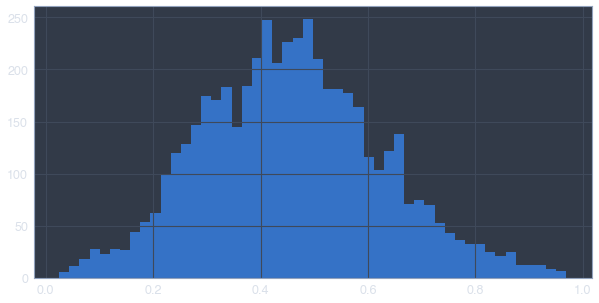

In [7]:
# Sanity check probability distribution
plt.figure(figsize=(10,5));
probs = [
    a for a, b in reg.predict_proba(predict_df)
]
plt.hist(probs, bins=50);

In [8]:
SIMULATION_ROUNDS = 1000
total_stats = defaultdict(lambda: defaultdict(int))
for i in tqdm(range(SIMULATION_ROUNDS)):
    # INITIALIZE BRACKET (will be updated durign simulation)
    slots_dict = {
        row["Seed"]: row
        for _, row in tournament_df.iterrows()
    }
    
    for i, r in slots_df.iterrows():
        team_a = slots_dict[r["StrongSeed"]]
        team_b = slots_dict[r["WeakSeed"]]
        predict_data = [[
            team_a["OwnScore_Zscore"],
            team_b["OwnScore_Zscore"],
            team_a["OppScore_Zscore"],
            team_b["OppScore_Zscore"],
            team_a["Offense"],
            team_b["Offense"],
            team_a["Dominance"],
            team_b["Dominance"],
            team_a["SOS"],
            team_b["SOS"],
        ]]
        prob = reg.predict_proba(scaler.transform(predict_data))[0][0]
        winning_team = team_a if random.random() > prob else team_b
        slots_dict[r["Slot"]] = winning_team
        total_stats[winning_team["TeamID"]]["wins"] += 1        
    
    # last winning team is champion
    total_stats[winning_team["TeamID"]]["championships"] +=1

100%|██████████| 1000/1000 [00:13<00:00, 76.77it/s]


In [9]:
simulation_df = pd.DataFrame([
    {
        "TeamID": team_id,
        "MeanWins": results_dict["wins"] / SIMULATION_ROUNDS,
        "PercentChampion": results_dict["championships"] / SIMULATION_ROUNDS
    }
    for team_id, results_dict in total_stats.items()
])
simulation_df = simulation_df.merge(tournament_df, on="TeamID")[[
    "TeamID", "TeamName", "Seed", "Offense", "Dominance", "SOS", "Wins", "MeanWins", "PercentChampion"
]]

In [10]:
def scatter_text(x, y, labelseries, labelsize='large', labelcolor='black', **kwargs):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x=x, y=y, **kwargs)
    # Add text besides each point
    for line in range(len(x)):
         p1.text(
             x[line]+0.02, y[line], 
             labelseries[line], size=labelsize, color=labelcolor
         )
    return p1

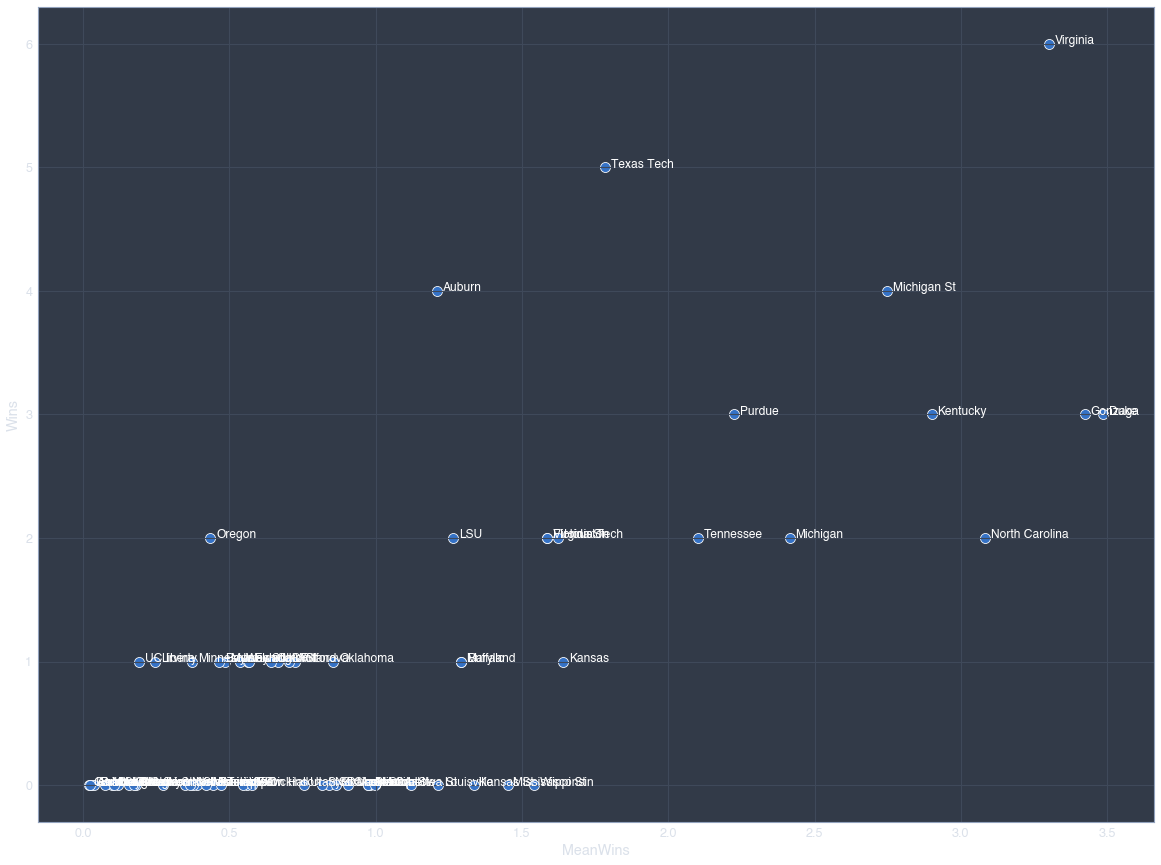

In [11]:
plt.figure(figsize=(20,15));
scatter_text(
    x=simulation_df["MeanWins"], y=simulation_df["Wins"], s=100,
    labelseries=simulation_df["TeamName"], labelcolor="white"
);

In [12]:
pie_df = simulation_df.sort_values("PercentChampion", ascending=False)
pie_df[:10]

,TeamID,TeamName,Seed,Offense,Dominance,SOS,Wins,MeanWins,PercentChampion
4,1181,Duke,W01,3.184682,6.358291,2.145184,3.0,3.486,0.212
11,1211,Gonzaga,X01,1.381132,7.827967,0.754181,3.0,3.424,0.167
27,1438,Virginia,Z01,-6.565747,5.101832,1.602299,6.0,3.302,0.131
19,1314,North Carolina,Y01,4.815520,5.325165,2.270579,2.0,3.082,0.106
5,1277,Michigan St,W02,1.114552,5.958277,1.966578,4.0,2.748,0.102
20,1246,Kentucky,Y02,-1.885967,5.289062,1.705029,3.0,2.900,0.063
12,1276,Michigan,X02,-5.322005,4.489226,1.748447,2.0,2.415,0.049
29,1345,Purdue,Z03,0.004010,3.949873,2.030139,3.0,2.224,0.030
28,1397,Tennessee,Z02,0.517909,4.730044,1.533066,2.0,2.103,0.021
22,1242,Kansas,Y04,1.523775,3.476421,2.219978,1.0,1.642,0.018


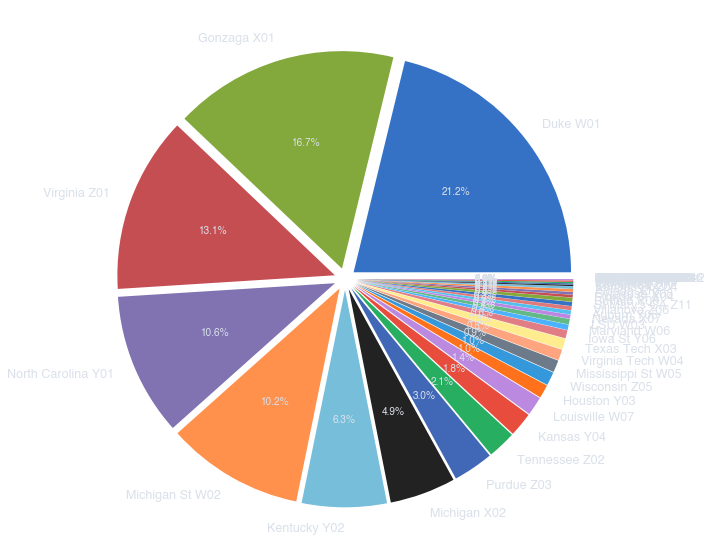

In [13]:
plt.figure(figsize=(10,10));
plt.pie(
    x=pie_df["PercentChampion"],
    labels=pie_df["TeamName"] + " " + pie_df["Seed"],
    autopct="%.1f%%",
    explode=[0.05]*len(simulation_df),
);